In [ ]:
! pip install transformers
! pip install seqeval

     |████████████████████████████████| 890kB 2.7MB/s 
     |████████████████████████████████| 890kB 13.7MB/s 
     |████████████████████████████████| 3.0MB 16.8MB/s 
     |████████████████████████████████| 1.1MB 41.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=6f5e24115ae4fa0ec60f36d8c8b02ee16fe90081d3f8cb2fe34becab26ccc76d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7423 sha256=04ec33215ca45f9d94660771c417f1e6bd552c2e8c95027d589d3827aea4fc0a
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange


In [ ]:
train = pd.read_csv('train.tsv', delimiter='\t', names=['word', 'label'], quoting=3, error_bad_lines=False)
test = pd.read_csv('test.tsv', delimiter='\t', names=['word', 'label'], quoting=3, error_bad_lines=False)
devel = pd.read_csv('devel.tsv', delimiter='\t', names=['word', 'label'], quoting=3, error_bad_lines=False)
train

,word,label
0,Immunostaining,O
1,and,O
2,confocal,O
3,analysis,O
4,DNA,O
...,...,...
2631834,no,O
2631835,competing,O
2631836,interests,O
2631837,exist,O


In [ ]:
def vet_frases(dataframe):
  sentences = []
  sentences_aux = []
  labels = []
  labels_aux = []
  for word, label in zip(dataframe.word.values, dataframe.label.values):
    sentences_aux.append(word)
    labels_aux.append(label)
    if (word == '.'):
      sentences.append(sentences_aux)
      labels.append(labels_aux)

      sentences_aux = []
      labels_aux = []
  return sentences, labels

In [ ]:
train_sentences, train_labels = vet_frases(train)
print(train_sentences[0])
print(train_labels[0])

['Immunostaining', 'and', 'confocal', 'analysis', 'DNA', 'labelling', 'and', 'staining', 'with', '5', '-', 'bromo', '-', '2', "'", '-', 'deoxyuridine', '(', 'BrdU', 'labelling', 'and', 'detection', 'kit', 'I', ';', 'Boehringer', 'Mannheim', ',', 'Germany', ')', 'was', 'performed', 'according', 'to', 'the', 'manufacturer', "'", 's', 'instructions', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
test_sentences, test_labels = vet_frases(train)
print(test_sentences[0])
print(test_labels[0])

['Immunostaining', 'and', 'confocal', 'analysis', 'DNA', 'labelling', 'and', 'staining', 'with', '5', '-', 'bromo', '-', '2', "'", '-', 'deoxyuridine', '(', 'BrdU', 'labelling', 'and', 'detection', 'kit', 'I', ';', 'Boehringer', 'Mannheim', ',', 'Germany', ')', 'was', 'performed', 'according', 'to', 'the', 'manufacturer', "'", 's', 'instructions', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
devel_sentences, devel_labels = vet_frases(devel)
print(devel_sentences[0])
print(devel_labels[0])

['Images', 'Figure', '1', 'Figure', '2', 'Figure', '3', 'Figure', '4', 'Results', 'Images', 'FIGURE', '2', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:

tag_values = list(set(train["label"].values))
tag_values.append("PAD")
print(sorted(tag_values))
tag2idx = {t: i for i, t in enumerate(tag_values)}

['B-Anatomy', 'B-Cancer', 'B-Cell', 'B-Chemical', 'B-Disease', 'B-Gene', 'B-Organ', 'B-Organism', 'B-Pathology', 'B-Protein', 'B-Taxon', 'B-Tissue', 'I-Anatomy', 'I-Cancer', 'I-Cell', 'I-Chemical', 'I-Disease', 'I-Gene', 'I-Organ', 'I-Organism', 'I-Pathology', 'I-Protein', 'I-Taxon', 'I-Tissue', 'O', 'PAD']


In [ ]:
print(len(tag_values))

26


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle

torch.__version__

'1.6.0+cu101'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()


In [ ]:
torch.cuda.get_device_name(0)


'Tesla K80'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('monologg/biobert_v1.1_pubmed', do_lower_case=False)

In [ ]:

MAX_LEN = 75
bs = 32

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []
    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [ ]:

train_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(train_sentences, train_labels)
]
test_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(test_sentences, test_labels)
]
devel_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(devel_sentences, devel_labels)
]


In [ ]:
print(train_tokenized_texts_and_labels[0])

(['I', '##mm', '##uno', '##sta', '##ining', 'and', 'con', '##fo', '##cal', 'analysis', 'DNA', 'label', '##ling', 'and', 'stain', '##ing', 'with', '5', '-', 'br', '##omo', '-', '2', "'", '-', 'de', '##ox', '##yu', '##rid', '##ine', '(', 'B', '##rd', '##U', 'label', '##ling', 'and', 'detection', 'kit', 'I', ';', 'Bo', '##eh', '##ring', '##er', 'Mann', '##heim', ',', 'Germany', ')', 'was', 'performed', 'according', 'to', 'the', 'manufacturer', "'", 's', 'instructions', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])


In [ ]:
train_tokenized_texts = [token_label_pair[0] for token_label_pair in train_tokenized_texts_and_labels]
train_labels = [token_label_pair[1] for token_label_pair in train_tokenized_texts_and_labels]
test_tokenized_texts = [token_label_pair[0] for token_label_pair in test_tokenized_texts_and_labels]
test_labels = [token_label_pair[1] for token_label_pair in test_tokenized_texts_and_labels]
devel_tokenized_texts = [token_label_pair[0] for token_label_pair in devel_tokenized_texts_and_labels]
devel_labels = [token_label_pair[1] for token_label_pair in devel_tokenized_texts_and_labels]

In [ ]:
print(train_tokenized_texts[0])

['I', '##mm', '##uno', '##sta', '##ining', 'and', 'con', '##fo', '##cal', 'analysis', 'DNA', 'label', '##ling', 'and', 'stain', '##ing', 'with', '5', '-', 'br', '##omo', '-', '2', "'", '-', 'de', '##ox', '##yu', '##rid', '##ine', '(', 'B', '##rd', '##U', 'label', '##ling', 'and', 'detection', 'kit', 'I', ';', 'Bo', '##eh', '##ring', '##er', 'Mann', '##heim', ',', 'Germany', ')', 'was', 'performed', 'according', 'to', 'the', 'manufacturer', "'", 's', 'instructions', '.']


In [ ]:
train_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in train_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
test_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in test_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
devel_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in devel_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [ ]:
train_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in train_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
test_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in test_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
devel_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in devel_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
train_attention_masks = [[float(i != 0.0) for i in ii] for ii in train_input_ids]
test_attention_masks = [[float(i != 0.0) for i in ii] for ii in test_input_ids]
devel_attention_masks = [[float(i != 0.0) for i in ii] for ii in devel_input_ids]

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags, tr_masks, val_masks = shuffle(train_input_ids, test_input_ids, train_tags, test_tags, train_attention_masks, test_attention_masks, random_state=2020)
devel_inputs, devel_tags, devel_masks = shuffle(devel_input_ids, devel_tags, devel_attention_masks, random_state=2020)

In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
devel_inputs = torch.tensor(devel_inputs)
devel_tags = torch.tensor(devel_tags)
devel_masks = torch.tensor(devel_masks)

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

devel_data = TensorDataset(devel_inputs, devel_masks, devel_tags)
devel_sampler = SequentialSampler(devel_data)
devel_dataloader = DataLoader(devel_data, sampler=devel_sampler, batch_size=bs)


In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


'3.1.0'

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "monologg/biobert_v1.1_pubmed",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


Some weights of the model checkpoint at monologg/biobert_v1.1_pubmed were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

In [ ]:
model.cuda();

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [ ]:
from seqeval.metrics import f1_score, accuracy_score


In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []
validation_accuracy, validation_f1 = [], []
for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print()
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()
    validation_accuracy.append(accuracy_score(pred_tags, valid_tags))
    validation_f1.append(f1_score(pred_tags, valid_tags))


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]


Average train loss: 0.25958637022447206
Validation loss: 0.15600564003945092
Validation Accuracy: 0.9432307442925185
Validation F1-Score: 0.7498608892319291



Epoch:  33%|███▎      | 1/3 [1:03:26<2:06:52, 3806.13s/it]


Average train loss: 0.15302765009683467
Validation loss: 0.10341007508272428
Validation Accuracy: 0.9613134959252245
Validation F1-Score: 0.8257654051212003



Epoch:  67%|██████▋   | 2/3 [2:06:56<1:03:27, 3807.49s/it]


Average train loss: 0.10627597965397689
Validation loss: 0.07756438478203884
Validation Accuracy: 0.9701803474332783
Validation F1-Score: 0.8598356155102398



Epoch: 100%|██████████| 3/3 [3:10:23<00:00, 3807.80s/it]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


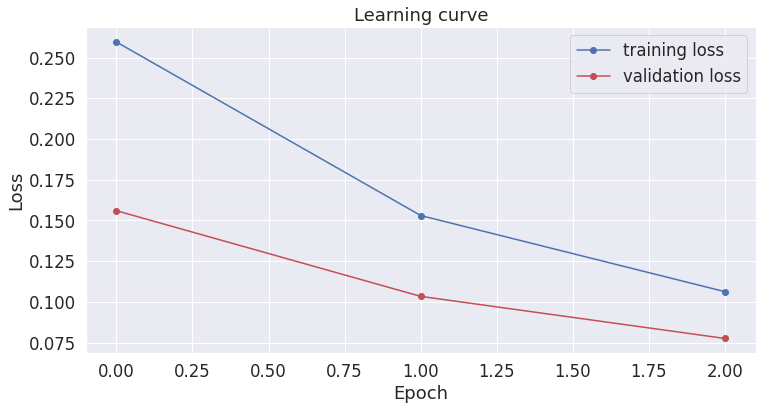

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


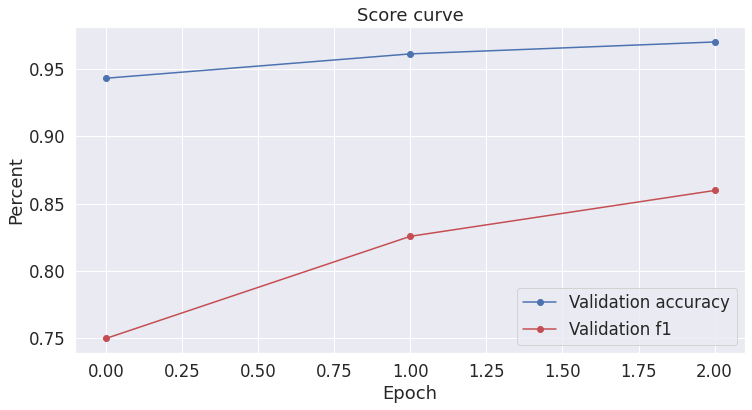

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(validation_accuracy, 'b-o', label="Validation accuracy")
plt.plot(validation_f1, 'r-o', label="Validation f1")
# Label the plot.
plt.title("Score curve")
plt.xlabel("Epoch")
plt.ylabel("Percent")
plt.legend()

plt.show()


In [ ]:
model.eval()
# Reset the validation loss for this epoch.
devel_loss, devel_accuracy = 0, 0
nb_devel_steps, nb_devel_examples = 0, 0
predictions , true_labels = [], []
for batch in devel_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients,
    # saving memory and speeding up validation
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have not provided labels.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
    # Move logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences.
    devel_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

devel_loss = devel_loss / len(devel_dataloader)
print("Devel loss: {}".format(devel_loss))
pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                              for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
valid_tags = [tag_values[l_i] for l in true_labels
                              for l_i in l if tag_values[l_i] != "PAD"]
print("Devel Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
print("Devel F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
print()


Devel loss: 0.22266485005947312
Devel Accuracy: 0.9335393231114344
Devel F1-Score: 0.6994633745203052



In [ ]:
test_sentence = """
This expression of NT-3 in supporting cells in embryos and neonates may even preserve in Brn3c null mutants the numerous spiral sensory neurons in the apex of 8-day old animals.Hypertensive pneumothorax is more common in tall and thin young adults (primary pneumothorax) or in patients with chronic pulmonary diseases or chest trauma (secondary pneumothorax).
"""
test_sentence1 = """
The cardiac and pulmonary auscultation are normal; chest pain does not worse with palpation of the thorax; there is no jugular stasis nor lower limb edema.
"""
test_sentence = """The pain is continuous and is located just in the middle of my chest, worsening when I breathe and when I lay down on my bed, I suffer from arterial hypertension and smoke 20 cigarettes every day."""

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()
with torch.no_grad():
    output = model(input_ids)
# print(output)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    print(token, label_idx)
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)
for token, label in zip(new_tokens, new_labels):
    print("{}\t\t{}".format(label, token))


[CLS] 19
The 19
pain 19
is 19
continuous 19
and 19
is 19
located 19
just 19
in 19
the 19
middle 19
of 19
my 19
chest 19
, 19
worse 19
##ning 19
when 19
I 19
breathe 19
and 19
when 19
I 19
lay 19
down 19
on 19
my 19
bed 19
, 19
I 19
suffer 19
from 19
art 19
##erial 19
h 19
##yper 19
##tens 19
##ion 19
and 19
smoke 19
20 19
cigarettes 19
every 19
day 19
. 19
[SEP] 19
O		[CLS]
O		The
O		pain
O		is
O		continuous
O		and
O		is
O		located
O		just
O		in
O		the
O		middle
O		of
O		my
O		chest
O		,
O		worsening
O		when
O		I
O		breathe
O		and
O		when
O		I
O		lay
O		down
O		on
O		my
O		bed
O		,
O		I
O		suffer
O		from
O		arterial
O		hypertension
O		and
O		smoke
O		20
O		cigarettes
O		every
O		day
O		.
O		[SEP]


In [ ]:
model.save_pretrained("biobert_model_ner")